### Test case LVV-T60 - Verify implementation of Publishing predicted visit schedule
Verify that a predict-visit schedule can be published by the OCS. <br>
DMS-REQ-0353-V-01: Publishing predicted visit schedule

### Specification: 
A service shall be provided to publish to the community the next visit location and the predicted visit schedule provided by the OCS. <br>
This service shall consist of both a web page for human inspection and a web API to allow automated tools to respond promptly.


In [1]:
import os
import requests
import pandas as pd

from urllib.parse import urlencode
from astropy.time import Time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Inspect the service

In [2]:
# URL for the service
obsloctap_url = "https://usdf-rsp-dev.slac.stanford.edu/obsloctap"

In [3]:
# Ping the service
response = requests.get(obsloctap_url)
assert response.status_code == 200, f"request failed with status {response.status_code}"

In [4]:
# Look at the header information
data = response.json()
assert data is not None

In [5]:
# Extract service response data 
for key in data.keys():
     print(f"{key}")

metadata


In [6]:
# Extract service metadata
md = data["metadata"]
print('Service Metadata:')
for key, value in md.items():
    print(f"{key}: {value}")

Service Metadata:
name: obsloctap
version: 0.3.3.dev2+g71bc47899
description: Look at scheduler forecast and track what was observed
repository_url: https://github.com/lsst-dm/obsloctap
documentation_url: https://obsloctap.lsst.io


In [7]:
print(f'ObsLocTap service running at USDF for "{md.get("description")}" with documentation at  url: {md.get("documentation_url")}')

ObsLocTap service running at USDF for "Look at scheduler forecast and track what was observed" with documentation at  url: https://obsloctap.lsst.io


As shown, the service is accessible programatically. Service metadata including the code and documantation  URLs are provided. The service does not require authentication.

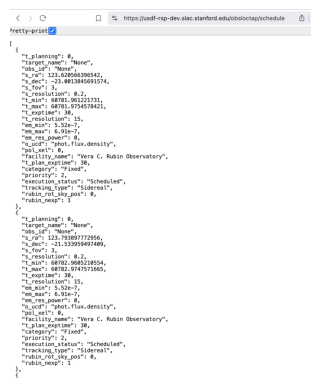

In [8]:
# Snapshot of the service 
img = mpimg.imread('../figures/test_LVV-T60.png')
plt.imshow(img)
plt.axis('off') 
plt.show()

## Predicted Visit Schedule
The schedule URL returns the next 24hrs of schedule by default. It returns the output of the simulator (the plan for the night observing).

In [9]:
# URL for schedule forecast 
schedule_url = obsloctap_url + "/schedule" 
assert schedule_url == "https://usdf-rsp-dev.slac.stanford.edu/obsloctap/schedule"

In [10]:
# Ping the service
response = requests.get(schedule_url)
assert response.status_code == 200, f"request failed with status {response.status_code}"

In [11]:
predicted_visit_schedule = response.json()
predicted_visit_schedule_df = pd.DataFrame(predicted_visit_schedule)
print(predicted_visit_schedule_df.head())

Empty DataFrame
Columns: []
Index: []


In [12]:
# Check the date of the next observation
if(len(predicted_visit_schedule_df) > 0): # Currently returning zero length -- Wil debugging
    mjd = predicted_visit_schedule_df.iloc[0]['t_planning']
    t = Time(mjd, format='mjd')
    date = t.to_value('iso', subfmt='date_hm').split()[0]
    print(date)
    assert date == params['start']

## Next Visit Location
Get the next visit location. Parameters include the start time and the duration into the future in hours. 

In [13]:
# Next visit location parameters - get the next 2 hours of observations from 2025-09-15
params = {
    "time": "2",
    "start": "2025-09-15"
}
next_visit_url = f"{schedule_url}?{urlencode(params)}"
print(next_visit_url)

https://usdf-rsp-dev.slac.stanford.edu/obsloctap/schedule?time=2&start=2025-09-15


In [14]:
response = requests.get(schedule_url, params=params)
print(response.url)
assert response.url == next_visit_url

https://usdf-rsp-dev.slac.stanford.edu/obsloctap/schedule?time=2&start=2025-09-15


In [15]:
assert response.status_code == 200, f"request failed with status {response.status_code}"

In [16]:
next_visits = response.json()
next_visits_df = pd.DataFrame(next_visits)
print(next_visits_df.head())

     t_planning   target_name        obs_id obs_collection        s_ra  \
0  60933.083293       lowdust       lowdust                 356.062687   
1  60933.083077  nes, lowdust  nes, lowdust                 350.490822   
2  60933.082842       lowdust       lowdust                 358.805722   
3  60933.082393       lowdust       lowdust                 358.975046   
4  60933.082179  nes, lowdust  nes, lowdust                 355.929853   

      s_dec  s_fov s_region  s_resolution         t_min  ...  pol_xel  \
0  0.113506    3.0                    0.2  60933.076349  ...        0   
1  2.258565    3.0                    0.2  60933.076133  ...        0   
2 -0.922718    3.0                    0.2  60933.075898  ...        0   
3 -3.832361    3.0                    0.2  60933.075449  ...        0   
4  2.999690    3.0                    0.2  60933.075234  ...        0   

   facility_name  instrument_name  t_plan_exptime  category  priority  \
0  Rubin:Simonyi          LSSTCam          

In [17]:
# Check the date of the next observation is correct given the start time passed
mjd = next_visits_df.iloc[0]['t_planning']
t = Time(mjd, format='mjd')
date = t.to_value('iso', subfmt='date_hm').split()[0]
assert date == params['start']

The next visit location service  is accessible programatically and can return the next X hours of visit locations from a specified start time. 